In [164]:
import os
import datetime
from uuid import uuid4
import logging
import io
import sys
import numpy as np
import pandas as pd
import random
import math
import scipy
from pandas.tseries.holiday import USFederalHolidayCalendar
# from concurrent.futures import ThreadPoolExecutor,ProcessPoolExecutor
# from multiprocessing import Pool

In [165]:
class LOGGER:
    def __init__(self):
        logger = logging.getLogger(__name__)
        feed = io.StringIO()

        fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        formatter = logging.Formatter(fmt)
        handler = logging.StreamHandler(feed)
        level = logging.WARNING

        handler.setFormatter(formatter)
        handler.setLevel(level)
        logger.addHandler(handler)
        logger.setLevel(level)
        
        self.logger = logger
        self.feed = feed

    def gen(self):
        return self.logger,self.feed

In [166]:
class ACCOUNT:
    
    """
    Consumer Deposits Collections
    Account level info
    """
    
    def __init__(self,today,entry_date,balance,age,dpd):
        self.log,self.feed = LOGGER().gen()
        self.id = uuid4()
        self.today = today
        
        self.balance = balance
        self.age = age
        self.dpd = dpd
        self.queue = None
        
        self.entry_date = entry_date
        self.next_call_date = entry_date
        self.last_call_date = None
        self.call_status = None
        
        self.end_date = None
        self.end_status = None
        self.charge_off_date = None
        self.exit_date = None
        
        #############
        ### LOGIC ###
        #############
        self.call_queues = {
            'BAU': {
                'balance': (100,1000),
                'age': (0,600),
                'dpd': (20,60),
                'frequency': 1, # weekly
            },
            '2X Weekly': {
                'balance': (1000,int(math.exp(100))),
                'age': (0,int(math.exp(100))),
                'dpd': (20,60),
                'frequency': 2, # weekly
            },
            '1 Call': {
                'balance': (100,1000),
                'age': (600,int(math.exp(100))),
                'dpd': (20,60),
                'frequency': 1, # weekly
            },
        }
            
    def exit(self):
        ###################
        ### ASSUMPTIONS ###
        ###################
        # future state - create model based on queue, balance, dpd, other attributes
        exit_likelihood = 0.2
        number = random.uniform(0,1)
        # self.log.info('Exit likelihood random number: {}'.format(number))
        if number <= exit_likelihood:
            self.end_date = self.today
            self.end_status = 'Exit'
            self.exit_date = self.today
        elif self.dpd == 56:
            self.end_status = 'Charge Off'
            self.charge_off_date = self.today
            self.end_date = self.today
            
    
    def update(self):
        # self.log.info('Updating account')
        if self.today >= self.entry_date:
            self.exit()
            # self.log.info('Account end status: {}'.format(self.end_status))
            if self.end_status is None:
                self.dpd += 1
                self.assign_queue()
        self.today += datetime.timedelta(days=1)
        
        if self.dpd > 56:
            raise Exception('DPD more than 56')
    
    def assign_queue(self):
        for queue,logic in self.call_queues.items():
            if (
                (self.balance >= logic['balance'][0])
                & (self.balance <= logic['balance'][1])
                & (self.age >= logic['age'][0])
                & (self.age <= logic['age'][1])
                & (self.dpd >= logic['dpd'][0])
                & (self.dpd <= logic['dpd'][1])
            ):
                self.queue = queue
                return
        
        raise Exception(
            'Unable to assign queue to account - age: {}, bal: {}, dpd: {}'
            .format(self.age,self.balance,self.dpd)
        )

In [167]:
class CALL_CENTER:
    
    """
    Consumer Deposits Collections
    Orchestrator for Call Center logic
    """
    
    def __init__(self,dates):
        self.log,self.feed = LOGGER().gen()
        
        ###################
        ### ASSUMPTIONS ###
        ###################
        self.call_outcomes = {
            'No Contact': {
                'likelihood': 0.8,
                'cooldown': 1, # days
            },
            'Customer Contact': {
                'likelihood': 0.15,
                'cooldown': 7, # days
            },
            'Payment Arranged': {
                'likelihood': 0.05,
                'cooldown': 14, # days
            },
        }
        
        self.data = {
            date: {
                'log': [],
                'total': 0,
                'queue': {
                    'bau': 0,
                    '2x weekly': 0,
                    '1 call': 0,
                },
                'outcome': {
                    'no contact': 0,
                    'customer contact': 0,
                    'payment arranged': 0,
                },
            }
            for date in dates
        }
            
    def call(self,account):
        if (
            (account.queue == '1 Call')
            & ((account.dpd < 35) | (account.dpd > 42))
        ):
            return None
        else:
            return 'MAKE CALL'
    
    def next_call_date(self,account):
        return account.next_call_date
    
    def log_data(self):
        None

In [168]:
class INVENTORY:
    
    """
    Consumer Deposits Collections
    Account inventory logic
    """
    
    def __init__(self):
        self.log,self.feed = LOGGER().gen()
        
        self.active = []
        self.inactive = []
                
        self.eff_start_date = datetime.date(2022,1,1)
        self.eff_end_date = datetime.date(2024,12,31)
        self.start_date = self.eff_start_date - datetime.timedelta(days=42)
        self.end_date = self.eff_end_date + datetime.timedelta(days=14)
        self.today = self.start_date
        self.dates = {}
        self.holidays = [
            date.date() for date
            in USFederalHolidayCalendar().holidays(start=self.start_date, end=self.end_date)
        ]
        for i in range((self.end_date - self.start_date).days + 1):
            date = self.start_date + datetime.timedelta(days=i)
            self.dates[date] = {
                'weekday': False if date.weekday() in [5,6] else True,
                'holiday': True if date in self.holidays else False,
                'effective': True if ((date>=self.eff_start_date) & (date<=self.eff_end_date)) else False,
            }
        
        self.data = {
            date : {
                **info,
                'entries': None,
                'active': None,
                'inactive': None,
                'queue': {
                    'bau': 0,
                    '2x weekly': 0,
                    '1 call': 0,
                },
            }
            for date,info in self.dates.items()
        }
        
        self.call_center = CALL_CENTER(
            [
                date for date,info in self.dates.items()
                if ((info['weekday']==True) & (info['holiday']==False))
            ]
        )
    
    def generate_accounts(self):
        ###################
        ### ASSUMPTIONS ###
        ###################
        # future state - use model to generate accounts
        base_daily_entries = 100
        for i in range(7):
            date = self.today + datetime.timedelta(days=i)
            self.log.info('Generate accounts date: {}'.format(date.strftime('%Y%m%d')))
            daily_entries = base_daily_entries + math.ceil((date - self.start_date).days/10)
            self.log.info('Daily entries: {}'.format(daily_entries))
            for entry in range(base_daily_entries):
                ###################
                ### ASSUMPTIONS ###
                ###################
                account = ACCOUNT(self.today,date,500,150,21)
                account.assign_queue()
                self.active.append(account)
            self.data[date]['entries'] = daily_entries
    
    def disribute_call_dates(self):
        # distribute accounts that got backed up over the weekend
        
        # get non-holiday weekdays over the next week
        dates = []
        workdays = []
        for i in range(7):
            date = self.today + datetime.timedelta(days=i)
            if date <= self.end_date:
                dates.append(date)
                if ((self.dates[date]['weekday'] is True) & (self.dates[date]['holiday'] is False)):
                    workdays.append(date)
        
        # calculate all the accounts that need to be called this week
        upcoming_calls = []
        for account in self.active:
            if account.next_call_date <= max(dates):
                upcoming_calls.append(account)
        
        # find the average number of calls per day needed to make these calls
        avg_calls_per_day = math.ceil(len(upcoming_calls)/len(workdays))
        
        # sort accounts queued to be called next week into called vs uncalled
        uncalled_and_queued = []
        called_and_queued = []
        for account in upcoming_calls:
            if account.last_call_date is None:
                uncalled_and_queued.append(account)
            else:
                called_and_queued.append(account)
        
        assigned = [] # track which accounts have been assigned a new next call date
        for date in workdays: # for each work day over the nexrt week
            cap = avg_calls_per_day # set the cap for the day
            queued = 0 # track the number of called queued for that day
            # first assign accounts from uncalled queue
            # then start filling in called accounts
            for queue in [uncalled_and_queued,called_and_queued]: 
                if queued >= cap:
                    break # break if already reached cap for the day
                for account in queue:
                    if queued >= cap: # break if reached cap for day
                        break
                    if ( # if the account is eligible for call this day
                        (date >= account.next_call_date)
                        # and the account hasn't already been assigned new call date
                        & (account not in assigned)
                    ): # set the next call date
                        account.next_call_date = date
                        # put account into assigned group
                        assigned.append(account)
                        # add one to the queued tracker
                        queued+=1

    def make_calls(self):
        for account in self.active:
            account.call_status = self.call_center.call(account)
            account.next_call_date = self.call_center.next_call_date(account)
        
    def log_data(self):
        active = 0
        for account in self.active:
            self.log.info(
                'Account entry date vs today: {} - {}'
                .format(account.entry_date.strftime('%Y%m%d'),self.today.strftime('%Y%m%d'))
            )
            if self.today >= account.entry_date:
                self.log.info('Counted as active')
                active += 1
        
        self.log.info('Active accounts: {}'.format(active))
        self.data[self.today]['active'] = active
        self.data[self.today]['inactive'] = len(self.inactive)
    
    def update_inventory(self):
        # update active inventory
        # with Pool() as pool:
        #     pool.map(lambda x: x.update(),self.active)
        for account in self.active:
            account.update()
        # rearrange inventory
        make_inactive = [account for account in self.active if account.end_status is not None]
        for account in make_inactive:
            self.active.remove(account)
            self.inactive.append(account)
    
    def run(self):
        if cnsmr_dep_colln.today > cnsmr_dep_colln.end_date:
            raise Exception('Reached the end of the simulation')
        
        # if day is saturday
        if self.today.weekday() == 5:
            # generate accounts on a weekly basis - so not processing a bunch of accounts unnecessarily
            self.generate_accounts()
            # distribute call dates that entered on weekend throughout weekdays
            self.disribute_call_dates()

        # on weekdays - make calls
        if self.today.weekday() in [0,1,2,3,4]:
            self.make_calls()
        
        self.log_data()
        self.call_center.log_data()
        # update info
        self.today += datetime.timedelta(days=1)
        self.update_inventory()

In [169]:
cnsmr_dep_colln = INVENTORY()

In [175]:
for i in range(300):
    cnsmr_dep_colln.run()

In [119]:
for date,info in cnsmr_dep_colln.data.items():
    if info['active'] is not None:
        print('{} ({}) - {}'.format(date,date.strftime('%a'),info['active']))

2022-01-01 (Sat) - 100
2022-01-02 (Sun) - 183
2022-01-03 (Mon) - 245
2022-01-04 (Tue) - 302
2022-01-05 (Wed) - 342
2022-01-06 (Thu) - 377
2022-01-07 (Fri) - 407
2022-01-08 (Sat) - 423
2022-01-09 (Sun) - 446
2022-01-10 (Mon) - 458
2022-01-11 (Tue) - 461
2022-01-12 (Wed) - 457
2022-01-13 (Thu) - 469
2022-01-14 (Fri) - 451
2022-01-15 (Sat) - 457
2022-01-16 (Sun) - 467
2022-01-17 (Mon) - 479
2022-01-18 (Tue) - 488
2022-01-19 (Wed) - 484
2022-01-20 (Thu) - 489
2022-01-21 (Fri) - 495
2022-01-22 (Sat) - 499
2022-01-23 (Sun) - 487
2022-01-24 (Mon) - 486
2022-01-25 (Tue) - 493
2022-01-26 (Wed) - 504
2022-01-27 (Thu) - 505
2022-01-28 (Fri) - 521
2022-01-29 (Sat) - 517
2022-01-30 (Sun) - 519
2022-01-31 (Mon) - 503
2022-02-01 (Tue) - 499
2022-02-02 (Wed) - 515
2022-02-03 (Thu) - 525
2022-02-04 (Fri) - 527
2022-02-05 (Sat) - 543
2022-02-06 (Sun) - 549
2022-02-07 (Mon) - 541
2022-02-08 (Tue) - 544
2022-02-09 (Wed) - 533
2022-02-10 (Thu) - 521
2022-02-11 (Fri) - 528
2022-02-12 (Sat) - 524
2022-02-13 

In [210]:
while cnsmr_dep_colln.today <= cnsmr_dep_colln.end_date:
    cnsmr_dep_colln.run()

In [45]:
class FORECAST:
    """
    Consumer Deposits Collections
    Forecast for new accounts entering collections
    """
    
    def __init__(self):
        None

In [15]:
import matplotlib.pyplot as plt

In [172]:
class GRAPH:
    
    def __init__(self,data):
        self.data = {
            date:info for date,info in data.items()
            if info['effective']==True
        }
    
    def scatter(self):
        None
    
    def line(self,metric):
        x = [date for date in self.data.keys()]
        y = [data[metric] for data in self.data.values()]
        y_name = metric.title()
        dates = x
        
        fig, ax = plt.subplots(figsize=(10,6), layout='tight')
        ax.plot(x, y, label=y_name)  # Plot some data on the axes
        ax.set_xlabel('Date')  # Add an x-label to the axes
        ax.set_ylabel(y_name)  # Add a y-label to the axes
        ax.set_title('Consumer Deposits Collections: {} Inventory over Time'.format(y_name))  # Add a title to the axes
        ax.legend()  # Add a legend
        # ax.set_xticklabels(x, rotation=45)
        ax.tick_params(labelrotation=45)
        
    def hist(self):
        None
    
    

In [ ]:
graph = GRAPH(cnsmr_dep_colln.data)

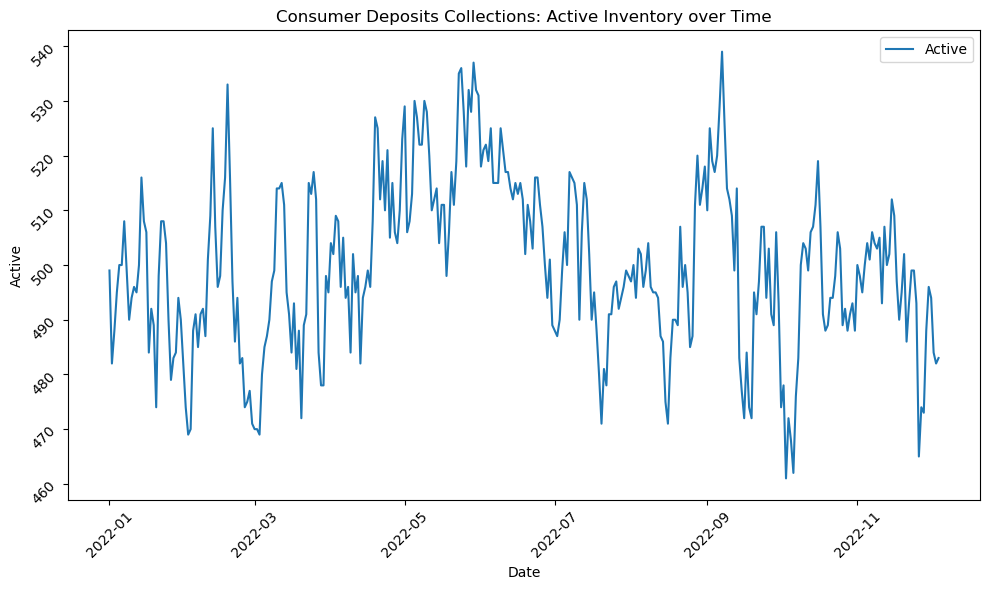

In [ ]:
graph.line('active')